In [1]:
import pandas as pd
import sys; sys.path.append('..')
from matplotlib.lines import Line2D
from utils.metrics import MetricsAdapter
import json
import numpy as np
import matplotlib as mpl; mpl.rcParams['figure.dpi'] = 600

NON_STAT = 9.775

# C-MLP configuration:
# buffer size = 50 (history length = 40)
# forecast length = 10
# hidden layer size = 100
# epochs per sample = 10

results = pd.read_csv('results_Ivol_Acc_Load_data3_w3_w2_50per_STD_downBy256.lvm.csv')\
            [['Time', 'Observed', 'Predicted']].rename(columns={'Predicted': 'I-MLP Predicted'})

# W-MLP configuration:
# sample window = 50
# training window = 100
# hidden layer size = 10
# epochs = 200

raw = json.loads(open('result-10n-s50-t100-e200.json', 'r').read())

results = results.merge(
    results[['Time']].join(
        pd.DataFrame({'W-MLP Predicted': np.array(raw['y_data'])}, index=np.array(raw['x_data'])),
        how='outer'),
    on='Time',
    how='outer')

max_time = results[['Time', 'Observed']].dropna().iloc[-1]['Time']
sample_rate = max_time / results[['Time', 'Observed']].dropna().shape[0]

rw_sizes = [1, int(1e-3 / sample_rate), int(10e-3 / sample_rate), int(100e-3 / sample_rate)]
rw_labels = ['per-sample', '1ms window', '10ms window', '100ms window']
plt_colors = ['lightsteelblue', 'dodgerblue', 'blue', 'purple']

valid_windows = []
rmse_legend = {}
mae_legend = {}

for i, s in enumerate(rw_sizes):
    if i == 0 or s > 1:
        color = plt_colors.pop(0)
        valid_windows.append((s, rw_labels[i], color))
        rmse_legend[f'RMSE {rw_labels[i]}'] = Line2D([0], [0], color=color, linewidth=3)
        mae_legend[f'MAE {rw_labels[i]}'] = Line2D([0], [0], color=color, linewidth=3)

cmlp_metrics = MetricsAdapter(
    results[['Time', 'Observed', 'I-MLP Predicted']].rename(columns={'I-MLP Predicted': 'Predicted'}))
wmlp_metrics = MetricsAdapter(
    results[['Time', 'Observed', 'W-MLP Predicted']].rename(columns={'W-MLP Predicted': 'Predicted'}))

for size, label, _ in valid_windows:
    if size == 1 or label != 'per-sample':
        cmlp_rmse_rolling = cmlp_metrics.rolling_rmse(size, f'I-MLP RMSE {label}')
        cmlp_mae_rolling = cmlp_metrics.rolling_mae(size, f'I-MLP MAE {label}')
        wmlp_rmse_rolling = wmlp_metrics.rolling_rmse(size, f'W-MLP RMSE {label}')
        wmlp_mae_rolling = wmlp_metrics.rolling_mae(size, f'W-MLP MAE {label}')
        
        results = results.merge(cmlp_rmse_rolling, on='Time', how='outer')
        results = results.merge(cmlp_mae_rolling, on='Time', how='outer')
        results = results.merge(wmlp_rmse_rolling, on='Time', how='outer')
        results = results.merge(wmlp_mae_rolling, on='Time', how='outer')

results['Time'] = results['Time'].apply(lambda x: x - NON_STAT)

results

,Time,Observed,I-MLP Predicted,W-MLP Predicted,I-MLP RMSE per-sample,I-MLP MAE per-sample,W-MLP RMSE per-sample,W-MLP MAE per-sample,I-MLP RMSE 10ms window,I-MLP MAE 10ms window,W-MLP RMSE 10ms window,W-MLP MAE 10ms window,I-MLP RMSE 100ms window,I-MLP MAE 100ms window,W-MLP RMSE 100ms window,W-MLP MAE 100ms window
0,-9.775000,0.024686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-9.770000,-0.054070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-9.765000,-0.009903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-9.760000,0.055296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-9.755000,-0.004513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,9.954988,NaN,0.005851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3947,9.959988,NaN,-0.066342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3948,9.964988,NaN,0.111183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3949,9.969988,NaN,-0.083868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


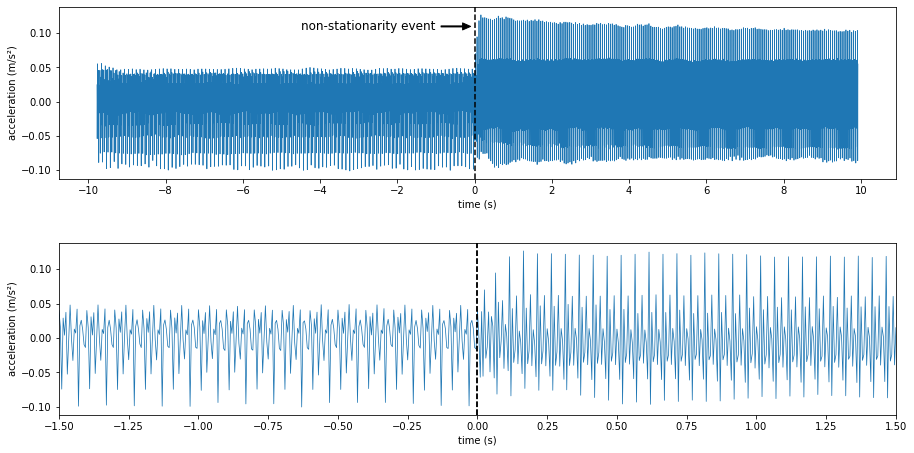

In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def query_time(lower, upper):
    return results.query(f'{lower} <= Time <= {upper}')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 7.5))

results.plot(y='Observed', x='Time', linewidth=0.75, ax=axs[0])
axs[0].xaxis.set_major_locator(MultipleLocator(base=2.0))

query_time(-1.5, 1.5).plot(y='Observed', x='Time', linewidth=0.75, ax=axs[1], xlim=[-1.5, 1.5])
axs[1].axvline(x=0, color='black', ls='--')
axs[1].xaxis.set_major_locator(MultipleLocator(base=0.25))

for ax in axs:
    ax.axvline(x=0, color='black', ls='--')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('acceleration (m/s²)')
    ax.get_legend().remove()
    
axs[0].annotate('non-stationarity event',
                xy=(0, 0.11),
                xytext=(-4.5, 0.11),
                verticalalignment='center',
                fontsize=12,
                arrowprops=dict(facecolor='black', shrink=0.1, width=1, headwidth=7, headlength=8))

plt.subplots_adjust(hspace=0.375)
plt.show()

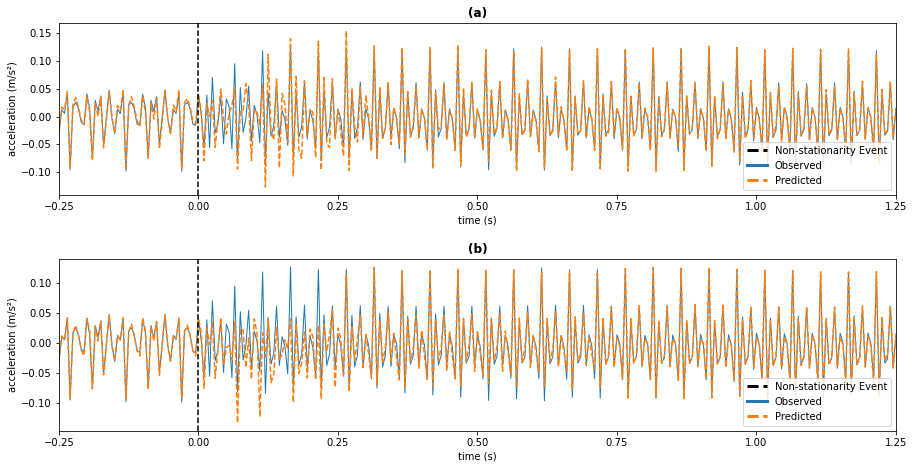

In [3]:
lo, hi = -0.25, 1.25

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 7.5))

for l, m, ax in zip(['(a)', '(b)'], ['I-MLP Predicted', 'W-MLP Predicted'], axs):
    query_time(lo, hi).plot(y='Observed', x='Time', linewidth=1, ax=ax, xlim=[lo, hi])
    query_time(lo, hi).plot(y=m, x='Time', color='tab:orange', linewidth=1.5, ax=ax, ls='--')
    ax.axvline(x=0, color='black', ls='--')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('acceleration (m/s²)')
    ax.set_title(l, fontweight='bold')
    ax.legend(
        [Line2D([0], [0], color='black', linewidth=3, ls='--'),
         Line2D([0], [0], color='tab:blue', linewidth=3),
         Line2D([0], [0], color='tab:orange', linewidth=3, ls='--')],
        ['Non-stationarity Event',
         'Observed',
         'Predicted'],
        loc='lower right')
    ax.xaxis.set_major_locator(MultipleLocator(base=0.25))
    
plt.subplots_adjust(hspace=0.375)
plt.show()

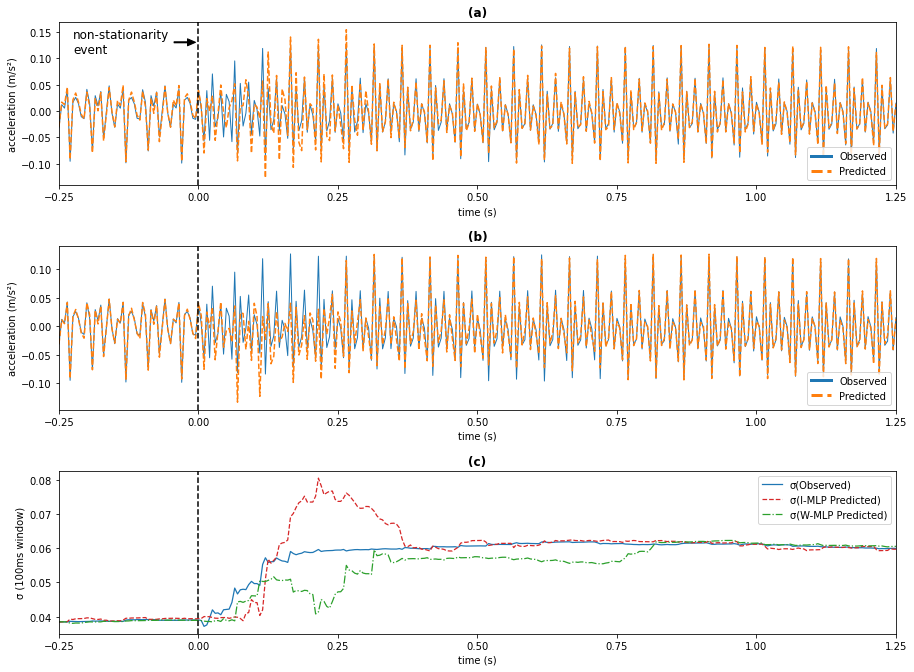

In [4]:
from sklearn.cluster import AgglomerativeClustering

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 3.75*3))

for l, m, ax in zip(['(a)', '(b)'], ['I-MLP Predicted', 'W-MLP Predicted'], axs[:2]):
    query_time(lo, hi).plot(y='Observed', x='Time', linewidth=1, ax=ax, xlim=[lo, hi])
    query_time(lo, hi).plot(y=m, x='Time', color='tab:orange', linewidth=1.5, ax=ax, ls='--')
    ax.axvline(x=0, color='black', ls='--')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('acceleration (m/s²)')
    ax.set_title(l, fontweight='bold')
    ax.legend(
        [Line2D([0], [0], color='tab:blue', linewidth=3),
         Line2D([0], [0], color='tab:orange', linewidth=3, ls='--')],
        ['Observed',
         'Predicted'],
        loc='lower right')
    ax.xaxis.set_major_locator(MultipleLocator(base=0.25))

def rolling_std(data):
    return (results[['Time', data]]
                   .set_index('Time')
                   .rolling(valid_windows[-1][0])
                   .std()
                   .query(f'{lo} <= Time <= {hi}'))

def calc_conv_time(model, tol, return_labels=False):
    obs_std = rolling_std('Observed')
    m_std = rolling_std(f'{model} Predicted')
               
    pts_within = (obs_std
                      .join(m_std)
                      .query(f'({1 - tol} * Observed) <= `{model} Predicted` <= ({1 + tol} * Observed)'))
    
    cluster_labels = (AgglomerativeClustering(n_clusters=3, linkage='single')
                          .fit_predict(np.reshape(pts_within.index, (-1, 1))))
    
    clustered_timepts = pd.DataFrame({
        'Time': pts_within.index,
        'Label': cluster_labels
    })
    
    conv_time = (clustered_timepts
                     .query(f'Label == {clustered_timepts.tail(1)["Label"].item()}')
                     .head(1)['Time']
                     .item())
    
    return (clustered_timepts,
            pts_within[[f'{model} Predicted']]) if return_labels else (pts_within[[f'{model} Predicted']],
                                                                       conv_time)

(rolling_std('Observed')
     .rename(columns={'Observed': 'σ[Observed]'})
     .plot(ax=axs[2], color='tab:blue', lw=1.25, xlim=[lo, hi]))
(rolling_std('I-MLP Predicted')
     .rename(columns={'I-MLP Predicted': 'σ[I-MLP Predicted]'})
     .plot(ax=axs[2], color='tab:red', lw=1.25, ls='--'))
(rolling_std('W-MLP Predicted')
     .rename(columns={'W-MLP Predicted': 'σ[W-MLP Predicted]'})
     .plot(ax=axs[2], color='tab:green', lw=1.25, ls='-.'))
axs[2].axvline(x=0, ls='--', color='k')
axs[2].set_title('(c)', fontweight='bold')
axs[2].set_xlabel('time (s)')
axs[2].set_ylabel('σ (100ms window)')
axs[2].xaxis.set_major_locator(MultipleLocator(base=0.25))

axs[0].annotate('non-stationarity\nevent',
                xy=(0, 0.13),
                xytext=(-0.225, 0.13),
                verticalalignment='center',
                fontsize=12,
                arrowprops=dict(facecolor='black', shrink=0.1, width=1, headwidth=7, headlength=8))

plt.subplots_adjust(hspace=0.375)
plt.show()

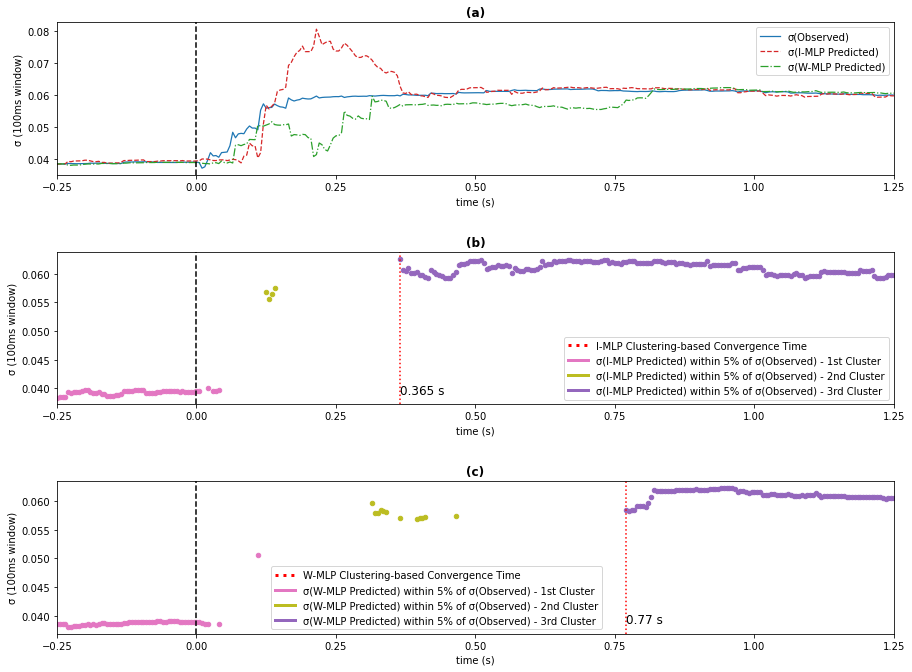

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, (3.75*3)))

(rolling_std('Observed')
     .rename(columns={'Observed': 'σ[Observed]'})
     .plot(ax=axs[0], color='tab:blue', lw=1.25, xlim=[lo, hi]))
(rolling_std('I-MLP Predicted')
     .rename(columns={'I-MLP Predicted': 'σ[I-MLP Predicted]'})
     .plot(ax=axs[0], color='tab:red', lw=1.25, ls='--'))
(rolling_std('W-MLP Predicted')
     .rename(columns={'W-MLP Predicted': 'σ(W-MLP Predicted)'})
     .plot(ax=axs[0], color='tab:green', lw=1.25, ls='-.'))
axs[0].axvline(x=0, ls='--', color='k')
axs[0].set_title('(a)', fontweight='bold')
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('σ (100ms window)')
axs[0].xaxis.set_major_locator(MultipleLocator(base=0.25))

for l, m, t, ax in zip(['(b)', '(c)'], ['I-MLP', 'W-MLP'] * 2, [0.05] * 2, axs[1:]):       
    labels, within = calc_conv_time(m, t, True)
    labelled = labels.set_index('Time').join(within).reset_index()
    last_label = labelled.tail(1)['Label'].item()
    first_label = labelled.head(1)['Label'].item()
    
    conv_time = labelled.query(f'Label == {last_label}').head(1)['Time'].item()
    
    (labelled
         .query(f'Label == {last_label}')
         .plot.scatter(y=f'{m} Predicted', x='Time', ax=ax, color='tab:purple', xlim=[lo, hi]))
    (labelled
         .query(f'Label == {first_label}')
         .plot.scatter(y=f'{m} Predicted', x='Time', ax=ax, color='tab:pink'))
    (labelled
         .query(f'Label != {last_label} and Label != {first_label}')
         .plot.scatter(y=f'{m} Predicted', x='Time', ax=ax, color='tab:olive'))
    
    ax.axvline(x=0, color='k', ls='--')
    ax.axvline(x=conv_time, color='red', ls=':')
    ax.annotate(f'{round(conv_time, 4)} s', xy=(conv_time, 1.05*ax.get_ylim()[0]), size=12)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('σ (100ms window)')
    ax.set_title(l, fontweight='bold')
    legend = ax.legend([Line2D([0], [0], color='red', lw=3, ls=':'),
               Line2D([0], [0], color='tab:pink', lw=3),
               Line2D([0], [0], color='tab:olive', lw=3),
               Line2D([0], [0], color='tab:purple', lw=3)],
              [f'{"I-MLP" if l == "(b)" else "W-MLP"} Clustering-based Convergence Time',
               f'σ({"I-MLP" if l == "(b)" else "W-MLP"} Predicted) '
               f'within {round(t*100)}% of σ(Observed) - 1st Cluster',
               f'σ({"I-MLP" if l == "(b)" else "W-MLP"} Predicted) '
               f'within {round(t*100)}% of σ(Observed) - 2nd Cluster',
               f'σ({"I-MLP" if l == "(b)" else "W-MLP"} Predicted) '
               f'within {round(t*100)}% of σ(Observed) - 3rd Cluster'],
              loc='best')
    if l == '(c)':
        legend.set_bbox_to_anchor((0.25, 0.475))
    else:
        legend.set_bbox_to_anchor((1, 0.475))
    ax.xaxis.set_major_locator(MultipleLocator(base=0.25))

plt.subplots_adjust(hspace=0.5)
plt.show()

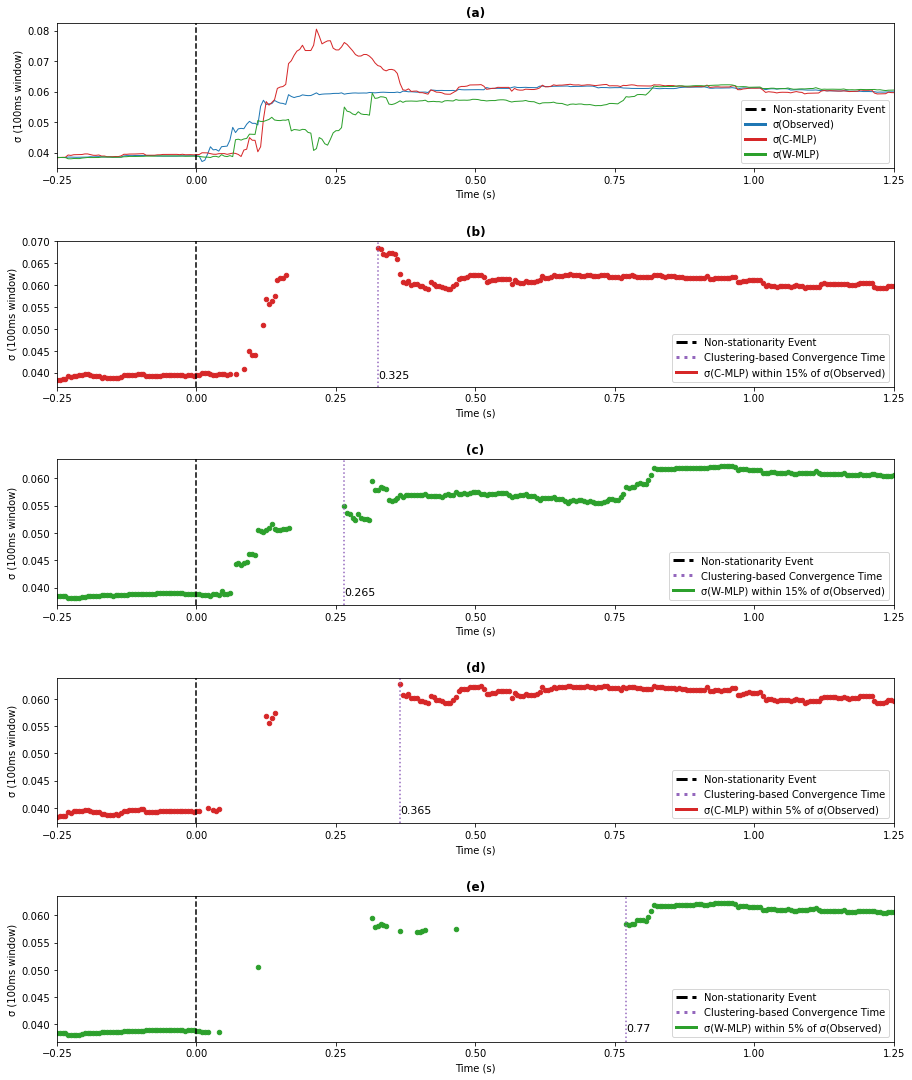

In [6]:
cmlp_within_15, cmlp_conv_15 = calc_conv_time('I-MLP', 0.15)
wmlp_within_15, wmlp_conv_15 = calc_conv_time('W-MLP', 0.15)
cmlp_within_05, cmlp_conv_05 = calc_conv_time('I-MLP', 0.05)
wmlp_within_05, wmlp_conv_05 = calc_conv_time('W-MLP', 0.05)

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 3.75*5))

rolling_std('Observed').plot(ax=axs[0], color='tab:blue', lw=1, xlim=[lo, hi])
rolling_std('I-MLP Predicted').plot(ax=axs[0], color='tab:red', lw=1)
rolling_std('W-MLP Predicted').plot(ax=axs[0], color='tab:green', lw=1)
axs[0].axvline(x=0, ls='--', color='k')
axs[0].set_title('(a)', fontweight='bold')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('σ (100ms window)')
axs[0].legend(
    [Line2D([0], [0], color='black', lw=3, ls='--'),
     Line2D([0], [0], color='tab:blue', lw=3),
     Line2D([0], [0], color='tab:red', lw=3),
     Line2D([0], [0], color='tab:green', lw=3)],
    ['Non-stationarity Event',
     'σ(Observed)',
     'σ(C-MLP)',
     'σ(W-MLP)'])
axs[0].xaxis.set_major_locator(MultipleLocator(base=0.25))

for l, df, t, ax in zip(['(b)', '(c)', '(d)', '(e)'],
                        [cmlp_within_15, wmlp_within_15, cmlp_within_05, wmlp_within_05],
                        [cmlp_conv_15, wmlp_conv_15, cmlp_conv_05, wmlp_conv_05],
                        axs[1:]):
    df.reset_index().plot.scatter(y=df.columns[0],
                                  x='Time',
                                  ax=ax,
                                  color='tab:red' if l in ['(b)', '(d)'] else 'tab:green',
                                  xlim=[lo, hi],
                                  marker='o')
    ax.axvline(x=0, color='k', ls='--')
    ax.axvline(x=t, color='tab:purple', ls=':')
    ax.annotate(round(t, 4), xy=(t, 1.05*ax.get_ylim()[0]), size=11)
    ax.set_title(l, fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('σ (100ms window)')
    ax.legend([Line2D([0], [0], color='k', lw=3, ls='--'),
               Line2D([0], [0], color='tab:purple', lw=3, ls=':'),
               Line2D([0], [0], color='tab:red' if l in ['(b)', '(d)'] else 'tab:green', lw=3)],
              ['Non-stationarity Event',
               'Clustering-based Convergence Time',
               f'σ({"C-MLP" if l in ["(b)", "(d)"] else "W-MLP"}) '
               f'within {15 if l in ["(b)", "(c)"] else 5}% of σ(Observed)'])
    ax.xaxis.set_major_locator(MultipleLocator(base=0.25))
    
plt.subplots_adjust(hspace=0.5)
plt.show()

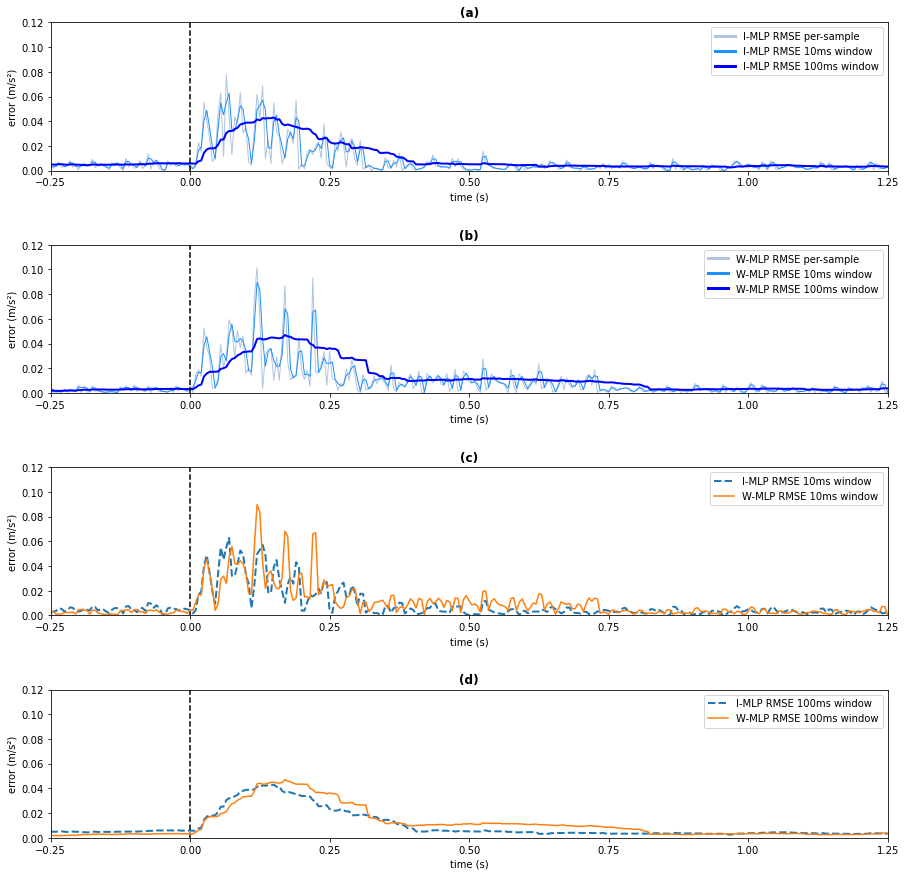

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 3.75*4))

for l, m_err, ax in zip(['(a)', '(b)'],
                        ['I-MLP RMSE', 'W-MLP RMSE'],
                        axs[:2]):
    for _, label, color in valid_windows:
        query_time(lo, hi).plot(y=f'{m_err} {label}',
                                x='Time',
                                color=color,
                                lw=2 if '100' in label else 1,
                                ax=ax,
                                xlim=[lo, hi])
    
    ax.axvline(x=0, color='k', ls='--')
    
    ax.xaxis.set_major_locator(MultipleLocator(base=0.25))
    ax.set_title(l, fontweight='bold')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('error (m/s²)')
    ax.legend(list(rmse_legend.values()),
               list(map(lambda s: f'{m_err.split()[0]} {s}', rmse_legend.keys())))
    
axs[2].axvline(x=0, color='k', ls='--')
axs[2].set_title('(c)', fontweight='bold')
axs[2].set_ylabel('error (m/s²)')
axs[2].set_ylim(*axs[0].get_ylim())
axs[2].xaxis.set_major_locator(MultipleLocator(base=0.25))
query_time(lo, hi).plot(y='I-MLP RMSE 10ms window', x='Time', xlim=[lo, hi], ax=axs[2], ls='--', lw=2)
query_time(lo, hi).plot(y='W-MLP RMSE 10ms window', x='Time', xlim=[lo, hi], ax=axs[2])
axs[2].set_xlabel('time (s)') 

axs[3].axvline(x=0, color='k', ls='--')
axs[3].set_title('(d)', fontweight='bold')
axs[3].set_ylabel('error (m/s²)')
axs[3].set_ylim(*axs[0].get_ylim())
axs[3].xaxis.set_major_locator(MultipleLocator(base=0.25))
query_time(lo, hi).plot(y='I-MLP RMSE 100ms window', x='Time', xlim=[lo, hi], ax=axs[3], ls='--', lw=2)
query_time(lo, hi).plot(y='W-MLP RMSE 100ms window', x='Time', xlim=[lo, hi], ax=axs[3])
axs[3].set_xlabel('time (s)')

for ax in axs:
    ax.set_ylim([0, 0.12])
    
plt.subplots_adjust(hspace=0.5)
plt.show()

In [13]:
query_time(lo, hi).query("`I-MLP RMSE 100ms window` < `W-MLP RMSE 100ms window` and 0.85 > Time > 0.3")

,Time,Observed,I-MLP Predicted,W-MLP Predicted,I-MLP RMSE per-sample,I-MLP MAE per-sample,W-MLP RMSE per-sample,W-MLP MAE per-sample,I-MLP RMSE 10ms window,I-MLP MAE 10ms window,W-MLP RMSE 10ms window,W-MLP MAE 10ms window,I-MLP RMSE 100ms window,I-MLP MAE 100ms window,W-MLP RMSE 100ms window,W-MLP MAE 100ms window
2016,0.305,-0.003819,-0.002669,-0.018869,0.024578,0.024578,0.000445,0.000445,0.017619,0.014337,0.001593,0.001326,0.019082,0.016357,0.026693,0.018009
2017,0.310,-0.060023,-0.062958,-0.057554,0.001150,0.001150,0.015050,0.015050,0.017398,0.012864,0.010646,0.007747,0.018779,0.015655,0.026582,0.017833
2018,0.315,0.122024,0.126885,0.125904,0.002935,0.002935,0.002469,0.002469,0.002229,0.002043,0.010784,0.008759,0.018380,0.014929,0.026561,0.017692
2029,0.370,-0.083236,-0.069100,-0.074679,0.003418,0.003418,0.000839,0.000839,0.006289,0.005814,0.002344,0.002023,0.011362,0.007544,0.012101,0.009526
2030,0.375,0.044827,0.044904,0.039374,0.014136,0.014136,0.008557,0.008557,0.010284,0.008777,0.006080,0.004698,0.010807,0.007195,0.012184,0.009667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,0.800,0.012514,0.015193,0.007166,0.002757,0.002757,0.002854,0.002854,0.002206,0.002108,0.002090,0.001811,0.003445,0.002943,0.006836,0.004694
2116,0.805,-0.002301,-0.000446,-0.000742,0.002679,0.002679,0.005348,0.005348,0.002718,0.002718,0.004286,0.004101,0.003374,0.002872,0.006907,0.004812
2117,0.810,-0.059854,-0.060869,-0.061117,0.001855,0.001855,0.001559,0.001559,0.002304,0.002267,0.003939,0.003453,0.003397,0.002936,0.006235,0.004221
2118,0.815,0.124000,0.121816,0.126082,0.001015,0.001015,0.001263,0.001263,0.001495,0.001435,0.001419,0.001411,0.003388,0.002912,0.005260,0.003533


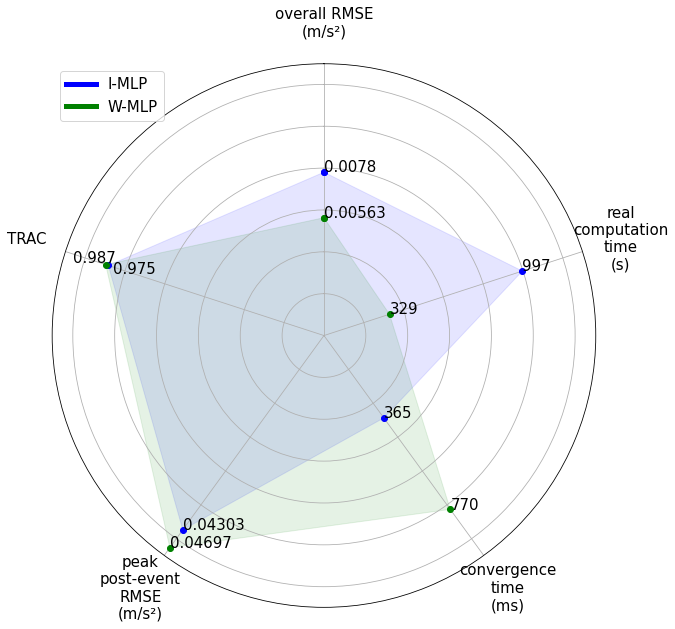

In [8]:
cmlp_rct = 996.788
wmlp_rct = 329.338

labels = np.array([
    'overall RMSE\n(m/s²)',
    'TRAC',
    'peak\npost-event\nRMSE\n(m/s²)',
    'convergence\ntime\n(ms)',
    'real\ncomputation\ntime\n(s)'
])

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

cmlp_rmse_peak = query_time(lo, hi).query('Time > 0')['I-MLP RMSE 100ms window'].max()
cmlp_values = np.array([
    cmlp_metrics.overall_rmse(),
    cmlp_metrics.trac() / 90,
    cmlp_rmse_peak / 3.75,
    cmlp_conv_05 / 75,
    cmlp_rct / 1e5
])

wmlp_rmse_peak = query_time(lo, hi).query('Time > 0')['W-MLP RMSE 100ms window'].max()
wmlp_values = np.array([
    wmlp_metrics.overall_rmse(),
    wmlp_metrics.trac() / 90,
    wmlp_rmse_peak / 3.75,
    wmlp_conv_05 / 75,
    wmlp_rct / 1e5
])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

angles = np.append(angles, angles[0])
cmlp_values = np.append(cmlp_values, cmlp_values[0])
wmlp_values = np.append(wmlp_values, wmlp_values[0])

ax.plot(angles, cmlp_values, color='blue', marker='o', lw=0)
ax.fill(angles, cmlp_values, alpha=0.1, color='blue')
ax.plot(angles, wmlp_values, color='green', marker='o', lw=0)
ax.fill(angles, wmlp_values, alpha=0.1, color='green')

ax.set_thetagrids((angles[:-1] * 180) / np.pi, labels)
ax.tick_params(labelsize=15, direction='out', pad=30)
ax.set_theta_offset(np.pi / 2)
ax.set_yticklabels([])
ax.legend(
    [Line2D([0], [0], color='blue', linewidth=5),
     Line2D([0], [0], color='green', linewidth=5)],
    ['I-MLP',
     'W-MLP'],
    loc='upper left',
    prop=dict(size=15))

size = 15

ax.annotate(round(cmlp_metrics.overall_rmse(), 5), (angles[0], cmlp_values[0]), fontsize=size)
ax.annotate(round(wmlp_metrics.overall_rmse(), 5), (angles[0], wmlp_values[0]), fontsize=size)

ax.annotate(round(cmlp_metrics.trac(), 3), (angles[1], cmlp_values[1]), fontsize=size,
                                                                        xytext=(2.05*np.pi/5, 0.0105))
ax.annotate(round(wmlp_metrics.trac(), 3), (angles[1], wmlp_values[1]), fontsize=size,
                                                                        xytext=(2.05*np.pi/5, 0.0125))

ax.annotate(round(cmlp_rmse_peak, 5), (angles[2], cmlp_values[2]), fontsize=size)
ax.annotate(round(wmlp_rmse_peak, 5), (angles[2], wmlp_values[2]), fontsize=size)

ax.annotate(round(cmlp_conv_05 * 1e3), (angles[3], cmlp_values[3]), fontsize=size)
ax.annotate(round(wmlp_conv_05 * 1e3), (angles[3], wmlp_values[3]), fontsize=size)

ax.annotate(round(cmlp_rct), (angles[4], cmlp_values[4]), fontsize=size)
ax.annotate(round(wmlp_rct), (angles[4], wmlp_values[4]), fontsize=size)

plt.show()